# Bach network

This work is a based on my previous work in this repo: https://github.com/araobp/learning-nlp

Date: 2024/01/05 - 2024/01/06

Reference: https://youtu.be/fAHkJ_Dhr50

Free book "Johann Sebastian Bach: His Life, Art, and Work" from Project Gutenberg: https://www.gutenberg.org/ebooks/35041

In [1]:
import spacy
from spacy import displacy
import re
nlp = spacy.load('en_core_web_trf')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


## Preprocessing and Paragraph-Level Splitting of the Original Text

In [2]:
import yaml

with open('../data/pg35041-paragraphs.yaml', 'r', encoding='utf-8') as f:
    paragraphs = yaml.safe_load(f.read())    

paragraphs[:3]

['If there is such a thing as inherited aptitude for art it certainly showed itself in the family of Bach.  For six successive generations scarcely two or three of its members are found whom nature had not endowed with remarkable musical talent, and who did not make music their profession.',
 'Veit Bach, ancestor of this famous family, gained a livelihood as a baker at Pressburg in Hungary.  When the religious troubles of the sixteenth century broke out he was driven to seek another place of abode, and having got together as much of his small property as he could, retired with it to Thuringia, hoping to find peace and security there.  He settled at Wechmar, a village near Gotha, where he continued to ply his trade as a baker and miller.In his leisure hours he was wont to amuse himself with the lute,playing it amid the noise and clatter of the mill.  His taste for music descended to his two sonsand their children, and in time the Bachs grew to be a very numerous family of professional m

In [3]:
len(paragraphs)

159

In [4]:
doc = nlp(paragraphs[36])
displacy.render(doc, style="ent", jupyter=True)

In [5]:
all_names = set()
for doc in nlp.pipe(paragraphs):
    for name in [ent.text for ent in doc.ents if ent.label_ == 'PERSON']:
        all_names.add(name)
all_names

{'Altnikol',
 'Amalia',
 'Anna Magdalena',
 'August Friedrich Müller',
 'Augustus II.',
 'Augustus III',
 'Bach',
 'Bachs',
 'Bass',
 'Beethoven',
 'Benda',
 'Berardi',
 'Bruhns',
 'Buononcini',
 'Buxtehude',
 'Böhm',
 'CARL PHILIPP EMMANUEL BACH',
 'Caldara',
 'Cantor',
 'Carl Philipp',
 'Carl Philipp Emmanuel',
 "Carl Philipp Emmanuel Bach's",
 "Carl Philipp Emmanuel's",
 "Carl Philipp's",
 'Charles',
 'Charles III.',
 'Christian',
 'Christian Weiss',
 'Christiana Eberhardine',
 'Clavichord',
 'Clavier',
 'Clavierhe',
 'Contrabasso',
 'Couperin',
 'Couperinhad',
 'Courantes',
 'Cöthen',
 'Dietrich Buxtehude',
 'Dresden',
 'Elias Gottlieb Haussmann',
 'Erdmann',
 'Ernesti',
 'Ernst August',
 'Fagotti',
 'Faustina',
 'Fischer',
 'Flemming',
 'Flutes',
 'Frederick the Great',
 'Frescobaldi',
 'Fritz Volbach',
 'Froberger',
 'Fux',
 'Georg Philipp Telemann',
 'Gesner',
 'Goldberg',
 'Gottlieb Kortte',
 'Grauns',
 'Görner',
 'H.Bach',
 'Handel',
 'Harpsichord',
 'Hasse',
 'Haussmann',
 'H

There are some items being mistakenly detected as names, such as Clavier (piano). From now on, these will be removed.

## Enumeration Search Function

In [6]:
# List of personal names for Removing Named Entities incorrectly detected as PERSON by spaCy
CLEANED_NAMES =['Anna Magdalena',
 'Bach',
 'Beethoven',
 'Böhm',
 'Bruhns',
 'Buxtehude',
 'Carl Philipp',
 'Carl Philipp Emmanuel',
 'Caspar Kerl',
 'Charles III',
 'Charles of Sicily',
 'Christopher Weigel',
 'Count Kaiserling',
 'Couperin',
 'Duke Christian of Weissenfels',
 'Duke Ernst',
 'Elias Gottlieb Haussmann',
 'Emmanuel Bach',
 'Forkel',
 'Fischer',
 'Frederick',
 'Frederick II',
 'Frederick the Great',
 'Frescobaldi',
 'Friedemann',
 'Friedrich Müller',
 'Fritz',
 'Fritz Volbach',
 'Froberger',
 'Georg Philipp Telemann',
 'Gottfried Baron van Swieten',
 'Görner',
 'Handel',
 'Hasse',
 'Haussmann',
 'Haydn',
 'Hence Bach',
 'Herein Bach',
 'Hoffmeister',
 'J. C. Gottsched',
 'Johann Ambrosius',
 'Johann Abraham Birnbaum',
 'Johann Adam Reinken',
 'Johann Ambrosius Bach',
 'Johann Bernhard Bach',
 'Johanna Caroline',
 'Johann Christian Hoffmann',
 'Johann Christoph',
 'Johann Christoph Bach',
 "Johann Christoph Friedrich's",
 'Johann G. Schübler',
 'Johann Gottlieb Görner',
 'Johann Caspar Kerl',               
 'Johann Heinrich Ernesti',
 'Johann Matthias Gesner',
 'Johann Michael Bach',
 'Johann Sebastian',
 'Johann Sebastian Bach',
 'Kühnel',
 'Kerl',
 'Maria Amalia',
 'Marianne von Ziegler',
 'Messrs',
 'Mozart',
 'Müller',
 'Nicolas',
 'Pachelbel',
 'Paul Wagner',
 'Peters',
 'Philipp Telemann',
 'Regine Susanna',
 'Reinhard Keiser',
 'Sebastian Bach',
 'Veit Bach',
 'Vereinigte Zwietracht',
 'Vierstimmige Choralgesänge',
 'Vivaldi',
 'Vom Himmel',
 'Wahre Grundsätze',
 'Wasserflüssen Babylon',
 'Wilhelm Friedemann']

# A list to convert Bach family names into full names
REPLACE = {'Bach': 'Johann Sebastian Bach',
           'Johann Sebastian': 'Johann Sebastian Bach',
           'Sebastian Bach': 'Johann Sebastian Bach',
           'Carl Philipp': 'Carl Philipp Emanuel Bach',
           'Carl Philipp Emanuel': 'Carl Philipp Emanuel Bach',
           'Carl Philipp Emmanuel': 'Carl Philipp Emanuel Bach', 
           'Emmanuel Bach': 'Carl Philipp Emanuel Bach',            
           'Wilhelm Friedemann': 'Wilhelm Friedemann Bach',
           'Friedemann': 'Wilhelm Friedemann Bach',
           'Johann Christoph': 'Johann Christoph Bach',
           'Anna Magdalena': 'Anna Magdalena Bach',
           'Regine Susanna': 'Regine Susanna Bach',
           'Johann Ambrosius': 'Johann Ambrosius Bach',
           'Frederick': 'Frederick II',
           'Frederick the Great': 'Frederick II'
          }

def align_names(namelist):
    namelist_ = [name.replace("'s", "") for name in namelist]
    return [REPLACE[name] if name in REPLACE else name for name in namelist_]

# Test
align_names(['Bach', 'Carl Philipp'])

['Johann Sebastian Bach', 'Carl Philipp Emanuel Bach']

In [7]:
# Search for the first token in the group
def findHead(token, head):
    if token.dep_ == 'conj':
        findHead(token.head, head)
    else:
        head.append(token)

# Search for tokens enumerated as PROPN
def findGroup(token, groups):
    for t in token.children:
        if (t.pos_ == 'PROPN' and t.dep_ == 'conj'):
            #print(t.head.text, t.text)
            head = []
            findHead(t, head)
            #print(head)
            head_ = head[0]
            if not head_ in groups:
                groups[head_] = [head_]
            groups[head_].append(t)
        try:
            first = next(t.children)
            findGroup(t, groups)
        except StopIteration:
            pass

# To obtain the full name, connect all PROPN entities bound by compound relationships
def fullname(token, text=False):
    name = []
    for t in token.children:
        if t.dep_ == 'compound':
            name.append(t)
    name.append(token)
    if text:
        return ' '.join([token.text for token in name])
    else:
        return name

# In a sentence, search for an enumeration of names, and return an array of enumeration groups 
# and an array of names that are not included in any enumeration group.
def findPersonsInGroup(doc, all_names=False, cleaned_names=False):
    groups = []

    # Remove names not in CLEANED_NAMES
    if cleaned_names:
        doc.ents = [ent for ent in doc.ents if ent.label_ == 'PERSON' and ent.text in CLEANED_NAMES]
    
    persons_ = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    spans = [[ent.start_char, ent.end_char] for ent in doc.ents]
    
    persons_ = align_names(persons_)
    persons = set(persons_)
    for token in doc:
        if token.dep_ == 'ROOT':
            root = token
            groups_ = {}
            findGroup(root, groups_)
            for group in groups_.values():
                fullname_list = [fullname(token, text=True) for token in group]
                fullname_list = align_names(fullname_list)
                # Extract PERSON only
                persons_fullname_list = [name for name in fullname_list if name in persons]
                #print(persons_fullname_list)
                if len(persons_fullname_list) > 0:
                    groups.append(set(persons_fullname_list))
    if not all_names:
        for group in groups:
            for name in group:
                persons.remove(name)
    return (groups, persons, spans)

## Generating weighted node-edge-node pairs on a paragraph basis.

In [8]:
import itertools

def isPairInGroup(node_a, node_b, groups):
    is_group_member = False
    for group in groups:
        if node_a in group and node_b in group:
            is_group_member = True
            break
    if is_group_member:
        weight = 2/len(group)  # The weights between members within the group exhibit an inverse proportional relationship.
    else:
        weight = 1  # The weight is always set to 1 outside the group.
    return (is_group_member, weight)

network = []
spans_in_paragraph = {}
p_idx = 0
for doc in nlp.pipe(paragraphs):
    for cleaned_names in (True, ):  # When checking for any missing names in CLEANED_NAMES, set it to (True, False).
        groups, persons, spans = findPersonsInGroup(doc, all_names=True, cleaned_names=cleaned_names)
        spans_in_paragraph[p_idx] = spans
        for node_pair in itertools.combinations(persons, r=2):
            weight = isPairInGroup(node_pair[0], node_pair[1], groups)
            network.append([p_idx, node_pair[0], node_pair[1], weight[1]])
    p_idx += 1

In [9]:
import pandas as pd
df = pd.DataFrame(network, columns=['p_idx', 'source', 'target', 'weight']).round(2)
df.sample(10)

,p_idx,source,target,weight
37,8,Böhm,Johann Caspar Kerl,0.29
124,76,Kerl,Vivaldi,1.00
79,52,Fritz Volbach,Johann Sebastian Bach,1.00
51,24,Görner,Georg Philipp Telemann,1.00
38,8,Froberger,Johann Caspar Kerl,0.29
12,8,Bruhns,Buxtehude,0.29
69,50,Johann Christian Hoffmann,Johann Abraham Birnbaum,1.00
103,76,Fischer,Kerl,0.25
88,53,Johann Christoph Friedrich,Johann Sebastian Bach,1.00
159,123,Hasse,Reinhard Keiser,0.67


## Output paragraph

In [10]:
[[key, spans_in_paragraph[key]] for key in list(spans_in_paragraph.keys())[:3]]

[[0, [[99, 103]]], [1, [[0, 9]]], [2, []]]

In [11]:
with open('../docs/paragraphs.js', 'w', encoding='utf-8') as f:
    f.write(f'var paragraphs = {paragraphs};\n\nvar spans = {spans_in_paragraph};')

## Sort source and target alphabetically for each node-edge-node pair.

In [12]:
def swap(row):
    if row.source > row.target:  # target is lphabetically before source
        source = row.source
        row.source = row.target
        row.target = source
    return row

df = df.apply(swap, axis=1)
df.sample(10)

,p_idx,source,target,weight
116,76,Bruhns,Böhm,0.25
85,53,Anna Magdalena Bach,Regine Susanna Bach,1.00
73,52,Elias Gottlieb Haussmann,Fritz Volbach,1.00
159,123,Hasse,Reinhard Keiser,0.67
111,76,Bruhns,Kerl,0.25
133,76,Frescobaldi,Pachelbel,0.25
89,53,Anna Magdalena Bach,Johann Christoph Friedrich,1.00
131,76,Buxtehude,Froberger,0.25
169,124,Hasse,Johann Sebastian Bach,1.00
86,53,Beethoven,Regine Susanna Bach,1.00


## Grouping by source and target

In [13]:
relationships_df = df.reset_index().groupby(['source', 'target'])[['p_idx', 'weight']].agg(list)
relationships_df['weight'] = relationships_df['weight'].apply(sum)
relationships_df = relationships_df.reset_index()
relationships_df.sample(10)

,source,target,p_idx,weight
100,Johann Caspar Kerl,Pachelbel,[8],0.29
41,Carl Philipp Emanuel Bach,Handel,[95],1.00
82,Hasse,Johann Sebastian Bach,"[123, 124]",2.00
11,Bruhns,Fischer,"[8, 76]",0.54
74,Georg Philipp Telemann,Johann Gottlieb Görner,[24],1.00
96,Johann Ambrosius Bach,Johann Christoph Bach,[7],1.00
2,Anna Magdalena Bach,Johann Sebastian Bach,"[33, 35, 53]",3.00
34,Böhm,Johann Christoph Bach,[8],1.00
27,Buxtehude,Kerl,[76],0.25
8,Beethoven,Wilhelm Friedemann Bach,[53],1.00


## Drawing a relational diagram with NetworkX

In [14]:
import networkx as nx
G = nx.from_pandas_edgelist(relationships_df,
                            source = 'source',
                            target = 'target',
                            edge_attr = ['weight', 'p_idx'],
                            create_using=nx.Graph())

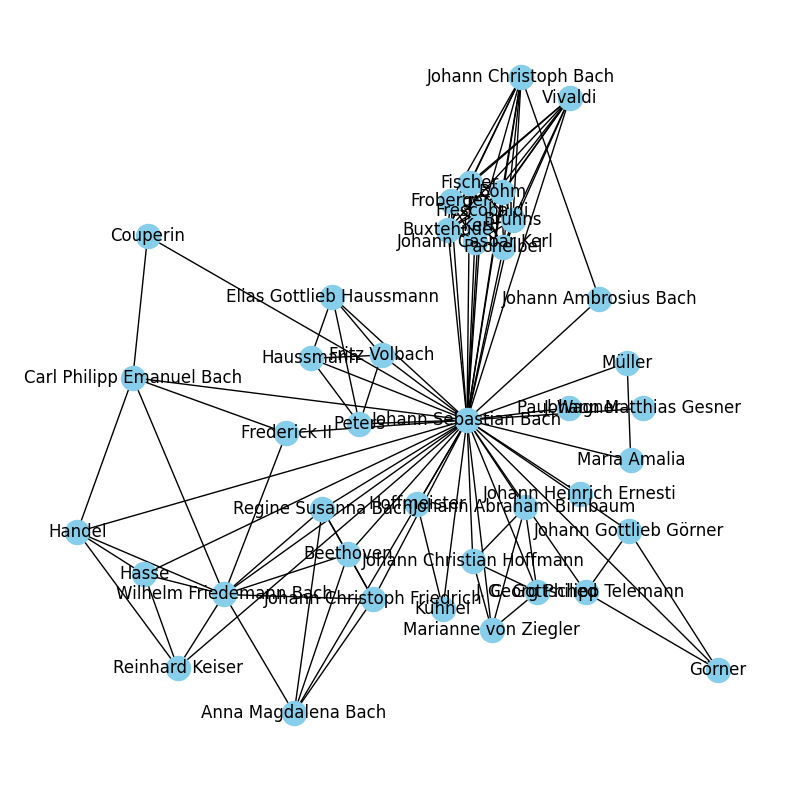

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, ax=ax, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

## Drawing a graph with pyvis

In [16]:
from pyvis.network import Network
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white', cdn_resources='in_line')

node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G, edge_scaling=True, show_edge_weights=True)
net.show('bach.html')

bach.html


## Centrality

<Axes: >

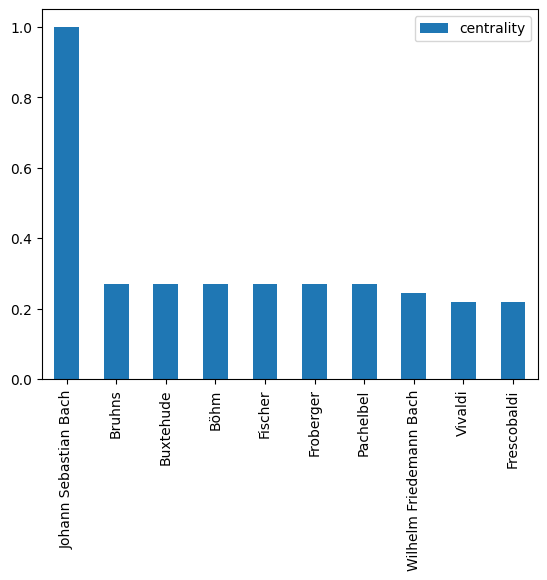

In [17]:
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

<Axes: >

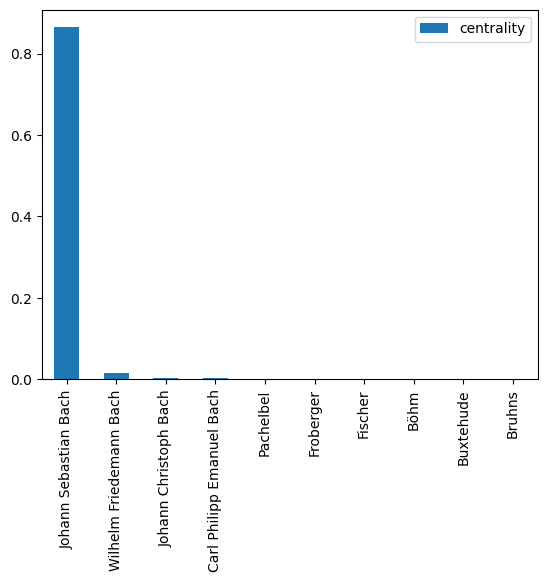

In [18]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

<Axes: >

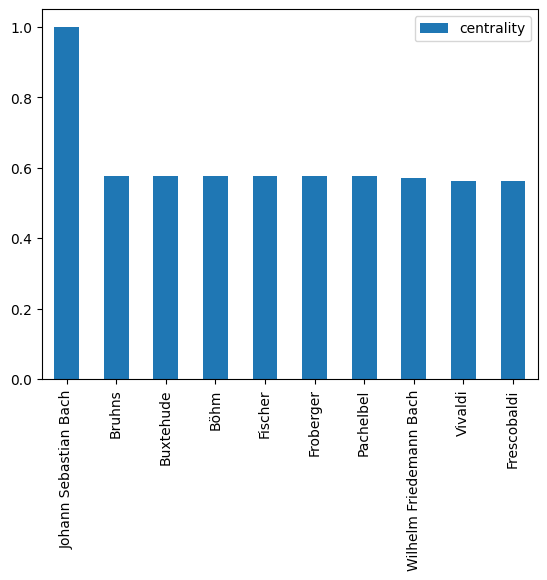

In [19]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

## Detecting communities

In [20]:
from community import community_louvain

communities = community_louvain.best_partition(G)
MAX_COMMUNITY_IDX = max(communities.values())

nx.set_node_attributes(G, communities, 'group')

com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='in_line')
com_net.from_nx(G)
com_net.show_buttons(filter_=['physics'])
com_net.show("bach_communities.html")

bach_communities.html


## HTML color list generation function for communities

In [21]:
import matplotlib.pyplot as plt
import random

def html_colors(max_group_index, cmap='rainbow'):

    def rgb2hex(cmap_color):
        r = int(cmap_color[0]*255)
        g = int(cmap_color[1]*255)
        b = int(cmap_color[2]*255)
        return "#{:02x}{:02x}{:02x}".format(r,g,b)
    
    cmap_idx = [i / max_group_index for i in range(0, max_group_index + 1 )]
    random.shuffle(cmap_idx)
    return [rgb2hex(plt.get_cmap(cmap)(i)) for i in cmap_idx]

In [22]:
colors = html_colors(MAX_COMMUNITY_IDX, 'Pastel1')

## Outputting data for graphology.js

In [23]:
nodes = []
for node in G.nodes.data(data=True):
    value = node[1]['size']
    group = node[1]['group']
    color = colors[group]
    nodes.append({'key': node[0], 'attributes': {'value': value, 'group': group, 'color': color}})
nodes

[{'key': 'Anna Magdalena Bach',
  'attributes': {'value': 5, 'group': 0, 'color': '#decbe4'}},
 {'key': 'Beethoven',
  'attributes': {'value': 5, 'group': 0, 'color': '#decbe4'}},
 {'key': 'Johann Christoph Friedrich',
  'attributes': {'value': 5, 'group': 0, 'color': '#decbe4'}},
 {'key': 'Johann Sebastian Bach',
  'attributes': {'value': 41, 'group': 1, 'color': '#e5d8bd'}},
 {'key': 'Regine Susanna Bach',
  'attributes': {'value': 5, 'group': 0, 'color': '#decbe4'}},
 {'key': 'Wilhelm Friedemann Bach',
  'attributes': {'value': 10, 'group': 0, 'color': '#decbe4'}},
 {'key': 'Bruhns',
  'attributes': {'value': 11, 'group': 2, 'color': '#fbb4ae'}},
 {'key': 'Buxtehude',
  'attributes': {'value': 11, 'group': 2, 'color': '#fbb4ae'}},
 {'key': 'Böhm', 'attributes': {'value': 11, 'group': 2, 'color': '#fbb4ae'}},
 {'key': 'Fischer',
  'attributes': {'value': 11, 'group': 2, 'color': '#fbb4ae'}},
 {'key': 'Frescobaldi',
  'attributes': {'value': 9, 'group': 2, 'color': '#fbb4ae'}},
 {'key

In [24]:
edges = []
for edge in G.edges.data(data=True):
    source = edge[0]
    target = edge[1]
    value = edge[2]['value']
    p_idxs = edge[2]['p_idx']
    edges.append({'key': f'{source}:{target}','source': source, 'target': target, 'attributes': {'value': value, 'pIdx': p_idxs}})
edges[:10]

[{'key': 'Anna Magdalena Bach:Beethoven',
  'source': 'Anna Magdalena Bach',
  'target': 'Beethoven',
  'attributes': {'value': 1.0, 'pIdx': [53]}},
 {'key': 'Anna Magdalena Bach:Johann Christoph Friedrich',
  'source': 'Anna Magdalena Bach',
  'target': 'Johann Christoph Friedrich',
  'attributes': {'value': 1.0, 'pIdx': [53]}},
 {'key': 'Anna Magdalena Bach:Johann Sebastian Bach',
  'source': 'Anna Magdalena Bach',
  'target': 'Johann Sebastian Bach',
  'attributes': {'value': 3.0, 'pIdx': [33, 35, 53]}},
 {'key': 'Anna Magdalena Bach:Regine Susanna Bach',
  'source': 'Anna Magdalena Bach',
  'target': 'Regine Susanna Bach',
  'attributes': {'value': 1.0, 'pIdx': [53]}},
 {'key': 'Anna Magdalena Bach:Wilhelm Friedemann Bach',
  'source': 'Anna Magdalena Bach',
  'target': 'Wilhelm Friedemann Bach',
  'attributes': {'value': 1.0, 'pIdx': [53]}},
 {'key': 'Beethoven:Johann Christoph Friedrich',
  'source': 'Beethoven',
  'target': 'Johann Christoph Friedrich',
  'attributes': {'value':

In [25]:
with open('../docs/graph_data.js', 'w', encoding='utf-8') as f:
    f.write(f'var nodes = {nodes};\n\nvar edges = {edges};')